# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.


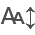

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)


In [3]:
# loading data
def load_data(filename="proshares_analysis_data.xlsx", directory="../data" ,sheet_name="hedge_fund_series"):
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        data = pd.read_excel(file_path, sheet_name=sheet_name,index_col=0,parse_dates=True)
        return data
    else:
        print("File not found.")
        return None


In [4]:
data =load_data(filename="spy_data.xlsx",sheet_name="total returns")
data.head()

SPY      ^IRX
date                          
1994-01-04  0.004035  0.000122
1994-01-05  0.002009  0.000122
1994-01-06  0.000000  0.000121
1994-01-07  0.006016  0.000119
1994-01-10  0.011960  0.000119

In [5]:
# Excess market returns

data["Excess Market Returns"] = data["SPY"] - data["^IRX"]
display("Excess Market Returns", data[["Excess Market Returns"]])

'Excess Market Returns'

Excess Market Returns
date                             
1994-01-04               0.003913
1994-01-05               0.001888
1994-01-06              -0.000121
1994-01-07               0.005897
1994-01-10               0.011841
...                           ...
2024-07-29               0.000384
2024-07-30              -0.005270
2024-07-31               0.016051
2024-08-01              -0.014364
2024-08-02              -0.018818

[7680 rows x 1 columns]

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

In [1]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import sys
notebook_dir = "practice"
if os.path.basename(os.getcwd()) == notebook_dir:
    os.chdir(os.pardir)  # Change to parent directory
    sys.path.append(os.getcwd())  # Add the new current directory to sys.path

import cmds.portfolio_management_helper as pmh
import functions.functions_andy as fa
print(os.getcwd())

c:\Users\Andik\OneDrive\Desktop\Chicago\Portfolio theory and risk management\githubrepo\finm-portfolio-2024


In [2]:
data = fa.load_data(filename="spy_data.xlsx", path="./data" ,sheet_name="total returns")
data.set_index("date", inplace=True)
data.head()

,SPY,^IRX
date,,
1994-01-04,0.0040,0.0001
1994-01-05,0.0020,0.0001
1994-01-06,0.0000,0.0001
1994-01-07,0.0060,0.0001
1994-01-10,0.0120,0.0001


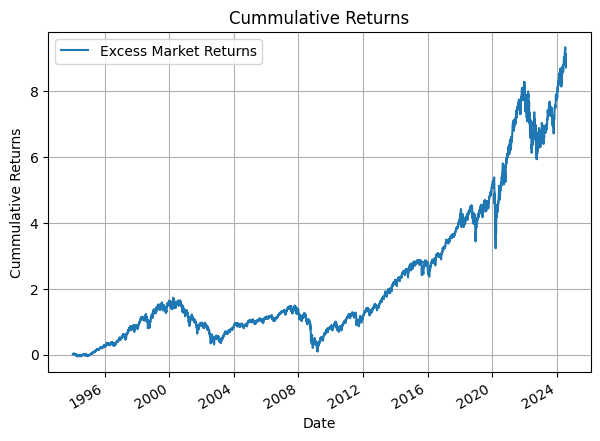

In [3]:
data["Excess Market Returns"] = data["SPY"] - data["^IRX"]
pmh.calc_cummulative_returns(returns = data["Excess Market Returns"],
                             return_plot=True
                             )

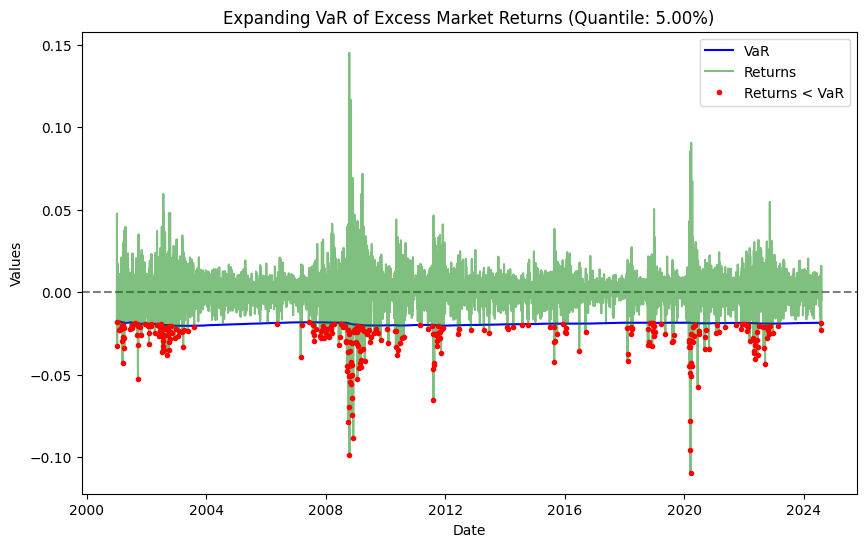

In [4]:
# historic VaR
excess_returns = data["Excess Market Returns"].copy()
start_date = pd.to_datetime("2000-12-29")
calculate_data = excess_returns.loc[:start_date]
excess_returns.expanding(min_periods=len(calculate_data)).quantile(0.05).shift(1).dropna()
VaR_df = fa.calculate_expanding_var(excess_returns,start_date,0.05, plot=True)

In [5]:
quantile = 0.05
hits = (VaR_df["Excess Market Returns"] < VaR_df["Excess Market Returns_VaR_0.05"]).value_counts()[True]
hit_ratio = hits / len(VaR_df)
hit_rate = np.abs((hit_ratio/quantile)-1)
print(f"Number of hits: {hits}")
print(f"Hit rate: {hit_rate:.5f}")
print(f"Hit ratio: {hit_ratio:.5f}")


Number of hits: 288
Hit rate: 0.02818
Hit ratio: 0.04859


In [6]:

from typing import Callable
def historical_rolling_var(return_series: pd.Series, percentile: float, window_size: int = 60) -> pd.Series:
    """
    Calculates the rolling Value at Risk (VaR) using a specified percentile and window size. Note no shifting is done.
    
    Parameters:
    ----------
    return_series : pd.Series
        The series of returns for which the rolling VaR is to be calculated.
        
    percentile : float
        The percentile for calculating the VaR (e.g., 0.05 for 5% VaR).
        
    window_size : int, optional (default=60)
        The size of the rolling window over which to calculate the VaR.
        
    Returns:
    -------
    pd.Series
        A series of the calculated rolling VaR values.
    """
    return return_series.rolling(window=window_size).quantile(percentile)


def historical_expanding_var(return_series: pd.Series, percentile: float = 0.05, window_size: int = 60) -> pd.Series:
    return return_series.expanding(min_periods=window_size).quantile(percentile)

def var_calculator(
    data: pd.DataFrame, 
    var_func: Callable[[pd.Series, float], pd.Series], 
    target_column: str, 
    var_name: str, 
    percentile: float, 
    window_size: int = 60, 
    start_date: str = "2001-01-01", 
    limit_plot: bool = True,
    plot_width: int = 10, 
    plot_height: int = 6,
    colors: list = ["blue", "red", "green"]
):
    """
    General function to calculate and plot Value at Risk (VaR) for specified data.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The input DataFrame containing the returns time series.
        
    var_func : Callable[[pd.Series, float], pd.Series]
        The function to be used for calculating VaR. It should accept a pd.Series and percentile as input.
        
    target_column : str
        The name of the column in `data` for which VaR is to be calculated.
        
    var_name : str
        The name to assign to the calculated VaR column.
        
    percentile : float
        The percentile for calculating the VaR (e.g., 0.05 for 5% VaR).
        
    window_size : int, optional (default=60)
        The size of the rolling window used by `var_func` for VaR calculation.
        
    start_date : str, optional (default="2001-01-01")
        The start date from which to begin plotting and calculating hit ratios.
        
    limit_plot : bool, optional (default=True)
        If True, limits the y-axis of the plot.
        
    plot_width : int, optional (default=10)
        The width of the plot.
        
    plot_height : int, optional (default=6)
        The height of the plot.
        
    colors : list, optional (default=["blue", "red", "green"])
        List of colors for plotting. Used for VaR line, highlighted points, and main data series respectively.
        
    Returns:
    -------
    None
    
    
    ```python
    
    
    
    # Example usage:
    var_calculator(
        data=spy_excess_returns, 
        var_func=historical_rolling_var, 
        target_column="SPY", 
        var_name="Historical 60 Rolling VaR 5%", 
        percentile=0.05,
        window_size=60,
        start_date="2001-01-01",
        limit_plot=True,
        plot_width=10, 
        plot_height=6,
        colors=["blue", "red", "green"]
    )
    ```
    
    
    """
    excess_returns = data.copy()
    excess_returns["Shifted"] = excess_returns[target_column].shift()
    
    # Calculate VaR using the provided function
    excess_returns[var_name] = var_func(excess_returns["Shifted"], percentile, window_size)
    
    # Drop NaN values and limit to start_date
    excess_returns = excess_returns.dropna(axis=0)
    excess_returns = excess_returns.loc[start_date:]

    # Plotting
    plt.figure(figsize=(plot_width, plot_height))
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    
    # Plot VaR line
    plt.plot(
        excess_returns.index,
        excess_returns[var_name],
        color=colors[0],
        label=var_name
    )
    
    # Plot main returns data
    plt.plot(
        excess_returns.index,
        excess_returns[target_column],
        color=colors[2],
        label=target_column,
        alpha=0.5
    )
    
    # Highlight returns below VaR
    returns_below_var = excess_returns[excess_returns[target_column] < excess_returns[var_name]]
    plt.plot(
        returns_below_var.index,
        returns_below_var[target_column],
        linestyle="",
        marker="o",
        color=colors[1],
        label=f"Returns < {var_name}",
        markersize=3
    )
    
    # Set y-axis limits if required
    if limit_plot:
        plt.ylim(min(excess_returns[target_column]), 0.01)
    
    # Calculate hit ratio
    hit_ratio = len(returns_below_var.index) / len(excess_returns.index)
    hit_ratio_error = abs((hit_ratio / percentile) - 1)
    
    
    # Add title and labels
    plt.title(f"{var_name} of {target_column}")
    plt.xlabel(f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}")
    plt.ylabel("Excess Returns")
    plt.legend()
    plt.show()




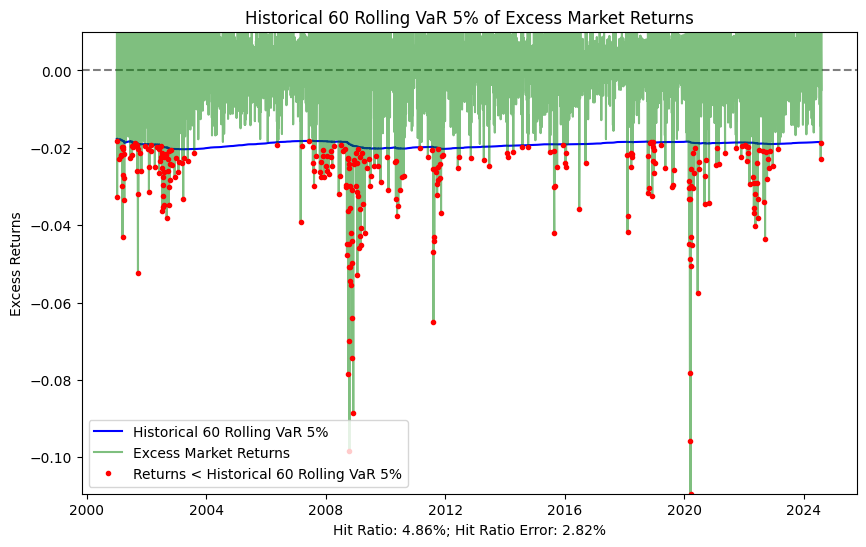

In [7]:
var_calculator(
    data=data, 
    var_func=historical_expanding_var, 
    target_column="Excess Market Returns", 
    var_name="Historical 60 Rolling VaR 5%", 
    percentile=0.05,
    window_size=60,
    start_date="2001-01-01",
    limit_plot=True,
    plot_width=10, 
    plot_height=6,
    colors=["blue", "red", "green"]
)

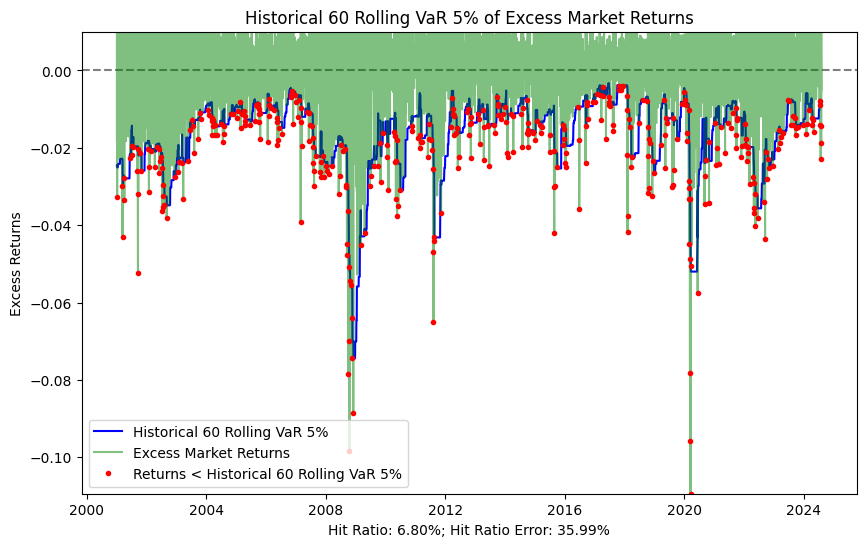

In [8]:
var_calculator(
    data=data, 
    var_func=historical_rolling_var, 
    target_column="Excess Market Returns", 
    var_name="Historical 60 Rolling VaR 5%", 
    percentile=0.05,
    window_size=60,
    start_date="2001-01-01",
    limit_plot=True,
    plot_width=10, 
    plot_height=6,
    colors=["blue", "red", "green"]
)

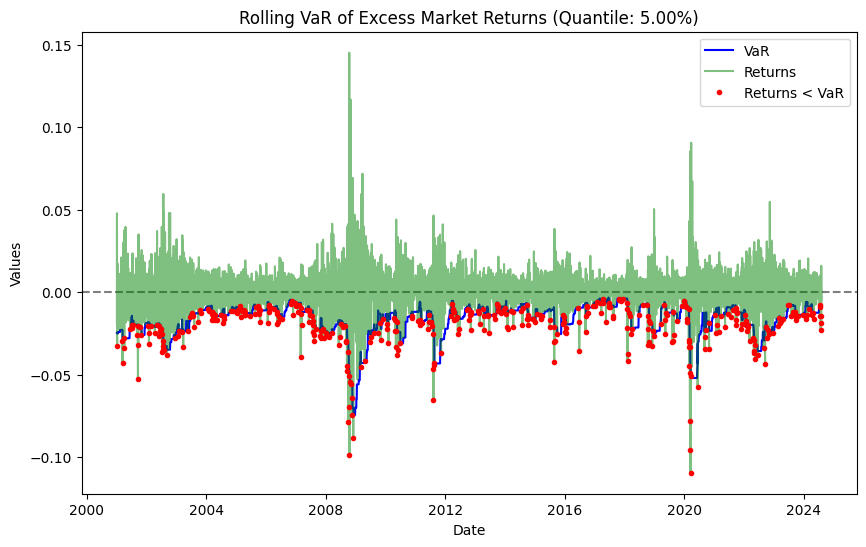

,Excess Market Returns,Excess Market Returns_Rolling_VaR_0.05
date,,
2001-01-02,-0.0183,-0.0246
2001-01-03,0.0478,-0.0246
2001-01-04,-0.0110,-0.0246
2001-01-05,-0.0328,-0.0246
2001-01-08,0.0075,-0.0251
...,...,...
2024-07-29,0.0004,-0.0079
2024-07-30,-0.0053,-0.0079
2024-07-31,0.0161,-0.0079


Number of hits: 403
Hit rate: 0.35988
Hit ratio: 0.06799


In [9]:
VaR_df = fa.calculate_rolling_var(data=data["Excess Market Returns"], end_training_date='2000-12-29', plot=True)
display(VaR_df)


# Frequency Calculation
quantile = 0.05
hits = (VaR_df["Excess Market Returns"] < VaR_df["Excess Market Returns_Rolling_VaR_0.05"]).value_counts()[True]
hit_ratio = hits / len(VaR_df)
hit_rate = np.abs((hit_ratio/quantile)-1)
print(f"Number of hits: {hits}")
print(f"Hit rate: {hit_rate:.5f}")
print(f"Hit ratio: {hit_ratio:.5f}")

In [25]:
def calculate_expanding_var(data: pd.DataFrame, start_date: str, column_name: str, quantile:float = 0.05) -> pd.DataFrame:
    """
    Calculates the expanding window Value at Risk (VaR) for a given column in a DataFrame starting from a specific date.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the VaR.
    column_name (str): The name of the column in `data` for which VaR is to be calculated.
    
    Returns:
    pd.DataFrame: A DataFrame with the original values and their corresponding VaR values.
    """
    first_date = pd.to_datetime(start_date)
    calculation_data = data.loc[:first_date, column_name]
    
    var_series = data.loc[:,column_name].expanding(min_periods=len(calculation_data)).quantile(quantile).shift(1)
    
    combined_data = pd.concat([data.loc[first_date:, column_name], var_series], axis=1).dropna()
    combined_data.columns = [column_name, f"{column_name}_VaR_{quantile}"]
    
    return combined_data
VaR_df = calculate_expanding_var(data, '2000-12-29', 'Excess Market Returns')
display(VaR_df)
frequency = (VaR_df["Excess Market Returns_VaR_0.05"] > VaR_df["Excess Market Returns"]).value_counts()
display(frequency)
print(f"Frequency of Excess Market Returns below VaR: {frequency[True]}")

,Excess Market Returns,Excess Market Returns_VaR_0.05
date,,
2001-01-02,-0.0183,-0.0177
2001-01-03,0.0478,-0.0178
2001-01-04,-0.0110,-0.0178
2001-01-05,-0.0328,-0.0178
2001-01-08,0.0075,-0.0179
...,...,...
2024-07-29,0.0004,-0.0185
2024-07-30,-0.0053,-0.0185
2024-07-31,0.0161,-0.0185


False    5639
True      288
Name: count, dtype: int64

Frequency of Excess Market Returns below VaR: 288


Historical VaR is not well-suited to predicting risks from extreme events that have not occurred in the past but could realistically happen in the future. Also, historical returns may not adequately reflect periods of increased market volatility. For instance, if the financial markets have been unusually calm, historical VaR might underestimate future risks. Furthermore, the effectiveness of the VaR estimate is highly dependent on the sample size and period it covers. Too short a time frame may not capture the full range of potential market behaviors, while too long a period may include outdated data that is no longer relevant.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

In [13]:
def calculate_expanding_vol(data: pd.DataFrame, start_date: str, column_name: str) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    """
    first_date = pd.to_datetime(start_date)
    # calculation_data = data.loc[:first_date, column_name]
    
    vol_series = data.loc[:,column_name].expanding(min_periods=2).apply(lambda x: np.sqrt(np.sum(x**2)/ (len(x)-1))).shift(1)
    vol_series.name = f"{column_name}_expanding_window_volatility"
    

    
    return vol_series.loc[first_date:].dropna()
expanding_vol_df = calculate_expanding_vol(data, '2001-01-02', 'Excess Market Returns')
display(expanding_vol_df)


date
2001-01-02   0.0111
2001-01-03   0.0111
2001-01-04   0.0112
2001-01-05   0.0112
2001-01-08   0.0112
              ...  
2024-07-29   0.0119
2024-07-30   0.0119
2024-07-31   0.0119
2024-08-01   0.0119
2024-08-02   0.0119
Name: Excess Market Returns_expanding_window_volatility, Length: 5927, dtype: float64

In [14]:
def expanding_vol(return_series: pd.Series) -> pd.Series:
    return np.sqrt((return_series ** 2).expanding(252).mean())
def rolling_vol(return_series: pd.Series) -> pd.Series:
    return np.sqrt((return_series ** 2).rolling(252).mean())
def calc_ewma_volatility(excess_returns: pd.Series, theta : float = 0.94, initial_vol : float = .2 / np.sqrt(252)) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(excess_returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=excess_returns.index)
display(expanding_vol(data["Excess Market Returns"].shift(1)).loc[pd.to_datetime("2001-01-02"):])
display(rolling_vol(data["Excess Market Returns"].shift(1)).loc[pd.to_datetime("2001-01-02"):])
display(calc_ewma_volatility(data["Excess Market Returns"],theta=0.94,initial_vol = .2 / np.sqrt(252)).shift(1).loc[pd.to_datetime("2001-01-02"):])

date
2001-01-02   0.0111
2001-01-03   0.0111
2001-01-04   0.0112
2001-01-05   0.0112
2001-01-08   0.0112
              ...  
2024-07-29   0.0119
2024-07-30   0.0119
2024-07-31   0.0119
2024-08-01   0.0119
2024-08-02   0.0119
Name: Excess Market Returns, Length: 5927, dtype: float64

date
2001-01-02   0.0150
2001-01-03   0.0151
2001-01-04   0.0152
2001-01-05   0.0152
2001-01-08   0.0153
              ...  
2024-07-29   0.0073
2024-07-30   0.0073
2024-07-31   0.0073
2024-08-01   0.0073
2024-08-02   0.0074
Name: Excess Market Returns, Length: 5927, dtype: float64

date
2001-01-02   0.0170
2001-01-03   0.0171
2001-01-04   0.0203
2001-01-05   0.0198
2001-01-08   0.0208
              ...  
2024-07-29   0.0085
2024-07-30   0.0082
2024-07-31   0.0081
2024-08-01   0.0087
2024-08-02   0.0092
Length: 5927, dtype: float64

In [15]:
def calculate_rolling_vol(data: pd.DataFrame, start_date: str, column_name: str, window_size: int =252) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    
    ```python
    rolling_vol_df = calculate_rolling_vol(data, '2001-01-02', 'Excess Market Returns')
    display(rolling_vol_df)
    ```
    
    """
    first_date = pd.to_datetime(start_date)
    vol_series = data.loc[:,column_name].rolling(window=window_size,center=False).apply(lambda x: np.sqrt(np.sum(x**2)/ window_size)).shift(1)
    
    # combined_data = pd.concat([data.loc[first_date:, column_name], vol_series], axis=1).dropna()
    vol_series.name = f"{column_name}_rolling_window_volatility"
    return vol_series.loc[first_date:].dropna()
rolling_vol_df = calculate_rolling_vol(data, '2001-01-02', 'Excess Market Returns')
display(rolling_vol_df)

date
2001-01-02   0.0150
2001-01-03   0.0151
2001-01-04   0.0152
2001-01-05   0.0152
2001-01-08   0.0153
              ...  
2024-07-29   0.0073
2024-07-30   0.0073
2024-07-31   0.0073
2024-08-01   0.0073
2024-08-02   0.0074
Name: Excess Market Returns_rolling_window_volatility, Length: 5927, dtype: float64

In [16]:
# Exponential moving Avg
def ewma_volatility(data: pd.DataFrame, start_date: str, column_name:str, theta: float = 0.94, initial_sigma: float = 0.20 / np.sqrt(252)) -> pd.Series:
    """
    Calculate EWMA volatility.
    
    Args:
    data (pd.Series): Time series of returns.
    theta (float): Decay factor for the EWMA.
    initial_sigma (float): Initial volatility estimate.
    
    Returns:
    pd.Series: EWMA volatility of the returns.
    
    ```python
    ewma_vol_df = ewma_volatility(data, '2001-01-02', 'Excess Market Returns')
    display(ewma_vol_df)
    display(pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1))
    ```
    
    """
    calculation_data = data[column_name]
    sigma_squared = np.zeros_like(calculation_data)
    sigma_squared[0] = initial_sigma**2
    
    for t in range(1, len(calculation_data)):
        sigma_squared[t] = theta * sigma_squared[t-1] + (1 - theta) * calculation_data.iloc[t-1]**2
    new_data = pd.Series(np.sqrt(sigma_squared), index=data.index).loc[start_date:,]
    new_data.name = f"{column_name}_EWMA_volatility"

    
    return new_data

ewma_vol_df = ewma_volatility(data, '2001-01-02', 'Excess Market Returns')
display(ewma_vol_df)
display(pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1))

print(type(ewma_vol_df.index), type(rolling_vol_df.index), type(expanding_vol_df.index))


date
2001-01-02   0.0170
2001-01-03   0.0171
2001-01-04   0.0203
2001-01-05   0.0198
2001-01-08   0.0208
              ...  
2024-07-29   0.0085
2024-07-30   0.0082
2024-07-31   0.0081
2024-08-01   0.0087
2024-08-02   0.0092
Name: Excess Market Returns_EWMA_volatility, Length: 5927, dtype: float64

,Excess Market Returns_expanding_window_volatility,Excess Market Returns_rolling_window_volatility,Excess Market Returns_EWMA_volatility
date,,,
2001-01-02,0.0111,0.0150,0.0170
2001-01-03,0.0111,0.0151,0.0171
2001-01-04,0.0112,0.0152,0.0203
2001-01-05,0.0112,0.0152,0.0198
2001-01-08,0.0112,0.0153,0.0208
...,...,...,...
2024-07-29,0.0119,0.0073,0.0085
2024-07-30,0.0119,0.0073,0.0082
2024-07-31,0.0119,0.0073,0.0081


<class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [17]:

def calculate_ewma_volatility(data: pd.DataFrame, start_date: str, column_name:str, theta: float = 0.94, initial_sigma: float = 0.20 / np.sqrt(252)) -> pd.Series:
    """
    Calculate EWMA volatility.
    
    Args:
    data (pd.Series): Time series of returns.
    theta (float): Decay factor for the EWMA.
    initial_sigma (float): Initial volatility estimate.
    
    Returns:
    pd.Series: EWMA volatility of the returns.
    
    ```python
    ewma_vol_df = calculate_ewma_volatility(data, '2001-01-02', 'Excess Market Returns')
    display(ewma_vol_df)
    display(pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1))
    ```
    
    """
    calculation_data = data[column_name]
    sigma_squared = np.zeros_like(calculation_data)
    sigma_squared[0] = initial_sigma**2
    
    for t in range(1, len(calculation_data)):
        sigma_squared[t] = theta * sigma_squared[t-1] + (1 - theta) * calculation_data.iloc[t-1]**2
    new_data = pd.Series(np.sqrt(sigma_squared), index=data.index).loc[start_date:,]
    new_data.name = f"{column_name}_EWMA_volatility"

    
    return new_data

def calculate_rolling_vol(data: pd.DataFrame, start_date: str, column_name: str, window_size: int =252) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    
    ```python
    rolling_vol_df = calculate_rolling_vol(data, '2001-01-02', 'Excess Market Returns')
    display(rolling_vol_df)
    ```
    
    """
    first_date = pd.to_datetime(start_date)
    vol_series = data.loc[:,column_name].rolling(window=window_size,center=False).apply(lambda x: np.sqrt(np.sum(x**2)/ window_size)).shift(1)
    
    # combined_data = pd.concat([data.loc[first_date:, column_name], vol_series], axis=1).dropna()
    vol_series.name = f"{column_name}_rolling_window_volatility"
    return vol_series.loc[first_date:].dropna()

def calculate_expanding_vol(data: pd.DataFrame, start_date: str, column_name: str) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    
    ```python
    expanding_vol_df = calculate_expanding_vol(data, '2001-01-02', 'Excess Market Returns')
    display(expanding_vol_df)
    ```
    
    
    """
    first_date = pd.to_datetime(start_date)
    # calculation_data = data.loc[:first_date, column_name]
    
    vol_series = data.loc[:,column_name].expanding(min_periods=2).apply(lambda x: np.sqrt(np.sum(x**2)/ (len(x)-1))).shift(1)
    vol_series.name = f"{column_name}_expanding_window_volatility"
    

    
    return vol_series.loc[first_date:].dropna()

def calculate_volatility(
    return_series: pd.Series, 
    method: str = "expanding", 
    window: int = 252, 
    theta: float = 0.94, 
    initial_vol: float = 0.2 / np.sqrt(252)
) -> pd.Series:
    """
    Calculate the volatility of a return series using different methods: expanding, rolling, or EWMA (Exponentially Weighted Moving Average).
    
    Parameters:
    ----------
    return_series : pd.Series
        A time series of returns for which volatility needs to be calculated.
        
    method : str, optional (default="expanding")
        The method to use for volatility calculation. Options include:
        - "expanding": Uses an expanding window to calculate volatility.
        - "rolling": Uses a rolling window to calculate volatility.
        - "ewma": Uses an exponentially weighted moving average to calculate volatility.
        
    window : int, optional (default=252)
        The size of the window for the rolling volatility calculation. Ignored if `method="ewma"` or `method="expanding"`.
        
    theta : float, optional (default=0.94)
        The decay factor used for EWMA volatility calculation. Only used if `method="ewma"`.
        
    initial_vol : float, optional (default=0.2 / sqrt(252))
        The initial volatility value used to seed the EWMA calculation. Only used if `method="ewma"`.
        
    Returns:
    -------
    pd.Series
        A time series of calculated volatility based on the selected method.
    
    Usage:
    -----
    ```python
    # Calculate expanding volatility
    expanding_volatility = calculate_volatility(data["Excess Market Returns"], method="expanding")
    display(expanding_volatility.shift(1).loc[pd.to_datetime("2001-01-02"):])
    
    # Calculate rolling volatility
    rolling_volatility = calculate_volatility(data["Excess Market Returns"], method="rolling", window=252)
    display(rolling_volatility.shift(1).loc[pd.to_datetime("2001-01-02"):])
    
    # Calculate EWMA volatility
    ewma_volatility = calculate_volatility(data["Excess Market Returns"], method="ewma", theta=0.94, initial_vol=0.2 / np.sqrt(252))
    display(ewma_volatility.shift(1).loc[pd.to_datetime("2001-01-02"):])
    ```
    
    Explanation:
    ------------
    The function allows for three methods of volatility calculation:
    - **Expanding Volatility**: Calculates the volatility over an expanding window, providing a cumulative measure that includes all data up to each point.
    - **Rolling Volatility**: Uses a fixed-size rolling window to calculate volatility, providing a moving measure that adapts as the window slides over time.
    - **EWMA Volatility**: Applies an exponentially weighted moving average to capture recent changes more sensitively, with a decay factor determining how much weight is given to recent vs. older data.
    """
    
    def expanding_vol(series: pd.Series) -> pd.Series:
        return np.sqrt((series ** 2).expanding().mean())

    def rolling_vol(series: pd.Series, window: int) -> pd.Series:
        return np.sqrt((series ** 2).rolling(window).mean())

    def calc_ewma_volatility(series: pd.Series, theta: float, initial_vol: float) -> pd.Series:
        var_t0 = initial_vol ** 2
        ewma_var = [var_t0]
        for i in range(len(series.index)):
            new_ewma_var = ewma_var[-1] * theta + (series.iloc[i] ** 2) * (1 - theta)
            ewma_var.append(new_ewma_var)
        ewma_var.pop(0)  # Remove var_t0
        ewma_vol = [np.sqrt(v) for v in ewma_var]
        return pd.Series(ewma_vol, index=series.index)

    # Select the method for volatility calculation
    if method == "expanding":
        return expanding_vol(return_series)
    elif method == "rolling":
        return rolling_vol(return_series, window)
    elif method == "ewma":
        return calc_ewma_volatility(return_series, theta, initial_vol)
    else:
        raise ValueError("Invalid method selected. Choose from 'expanding', 'rolling', or 'ewma'.")




Expanding Volatility Results:


date
2001-01-02   0.0111
2001-01-03   0.0111
2001-01-04   0.0112
2001-01-05   0.0112
2001-01-08   0.0112
              ...  
2024-07-29   0.0119
2024-07-30   0.0119
2024-07-31   0.0119
2024-08-01   0.0119
2024-08-02   0.0119
Name: Excess Market Returns_expanding_window_volatility, Length: 5927, dtype: float64

Expanding Volatility (General Function) Results:


date
2001-01-02   0.0111
2001-01-03   0.0111
2001-01-04   0.0112
2001-01-05   0.0112
2001-01-08   0.0112
              ...  
2024-07-29   0.0119
2024-07-30   0.0119
2024-07-31   0.0119
2024-08-01   0.0119
2024-08-02   0.0119
Name: Excess Market Returns, Length: 5927, dtype: float64

Differences in Expanding Volatility Calculation:


date
2001-01-02   0.0111
2001-01-03   0.0111
2001-01-04   0.0112
2001-01-05   0.0112
2001-01-08   0.0112
              ...  
2015-07-17   0.0121
2015-07-20   0.0121
2015-07-21   0.0121
2015-07-22   0.0121
2015-07-23   0.0121
Name: Excess Market Returns_expanding_window_volatility, Length: 3656, dtype: float64

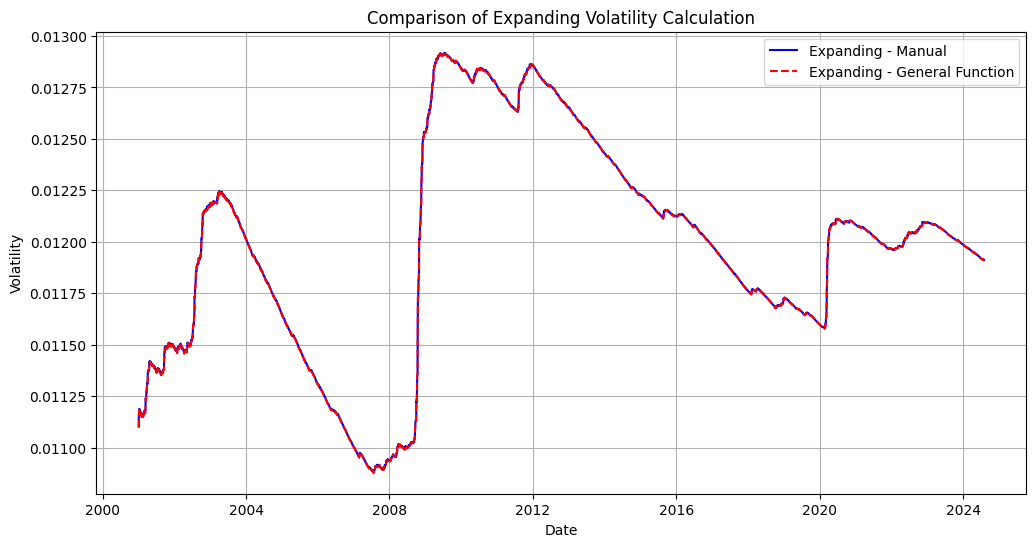

Rolling Volatility Results:


date
2001-01-02   0.0150
2001-01-03   0.0151
2001-01-04   0.0152
2001-01-05   0.0152
2001-01-08   0.0153
              ...  
2024-07-29   0.0073
2024-07-30   0.0073
2024-07-31   0.0073
2024-08-01   0.0073
2024-08-02   0.0074
Name: Excess Market Returns_rolling_window_volatility, Length: 5927, dtype: float64

Rolling Volatility (General Function) Results:


date
2001-01-02   0.0150
2001-01-03   0.0151
2001-01-04   0.0152
2001-01-05   0.0152
2001-01-08   0.0153
              ...  
2024-07-29   0.0073
2024-07-30   0.0073
2024-07-31   0.0073
2024-08-01   0.0073
2024-08-02   0.0074
Name: Excess Market Returns, Length: 5927, dtype: float64

Differences in Rolling Volatility Calculation:


Series([], Name: Excess Market Returns_rolling_window_volatility, dtype: float64)

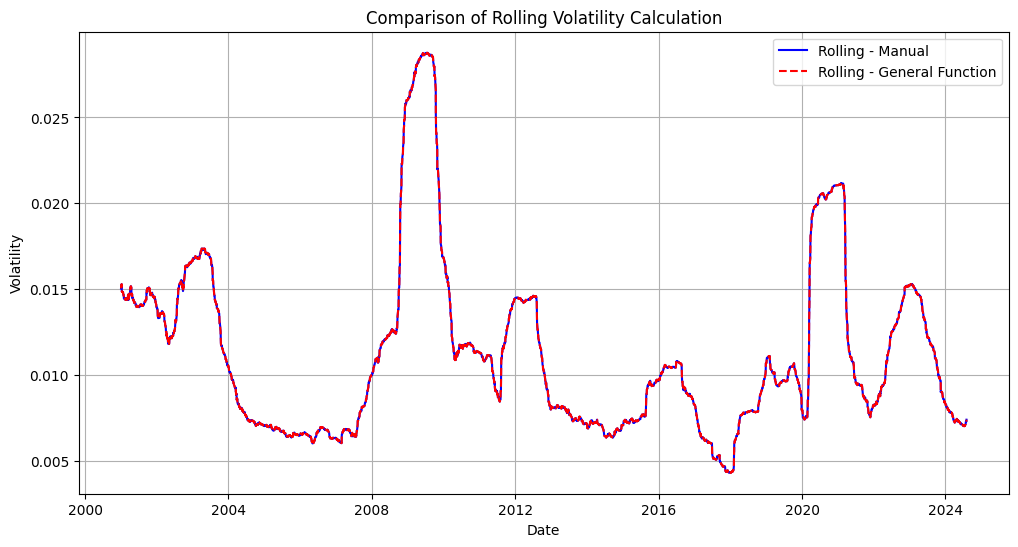

EWMA Volatility Results:


date
2001-01-02   0.0170
2001-01-03   0.0171
2001-01-04   0.0203
2001-01-05   0.0198
2001-01-08   0.0208
              ...  
2024-07-29   0.0085
2024-07-30   0.0082
2024-07-31   0.0081
2024-08-01   0.0087
2024-08-02   0.0092
Name: Excess Market Returns_EWMA_volatility, Length: 5927, dtype: float64

EWMA Volatility (General Function) Results:


date
2001-01-02   0.0170
2001-01-03   0.0171
2001-01-04   0.0203
2001-01-05   0.0198
2001-01-08   0.0208
              ...  
2024-07-29   0.0085
2024-07-30   0.0082
2024-07-31   0.0081
2024-08-01   0.0087
2024-08-02   0.0092
Length: 5927, dtype: float64

Differences in EWMA Volatility Calculation:


Series([], Name: Excess Market Returns_EWMA_volatility, dtype: float64)

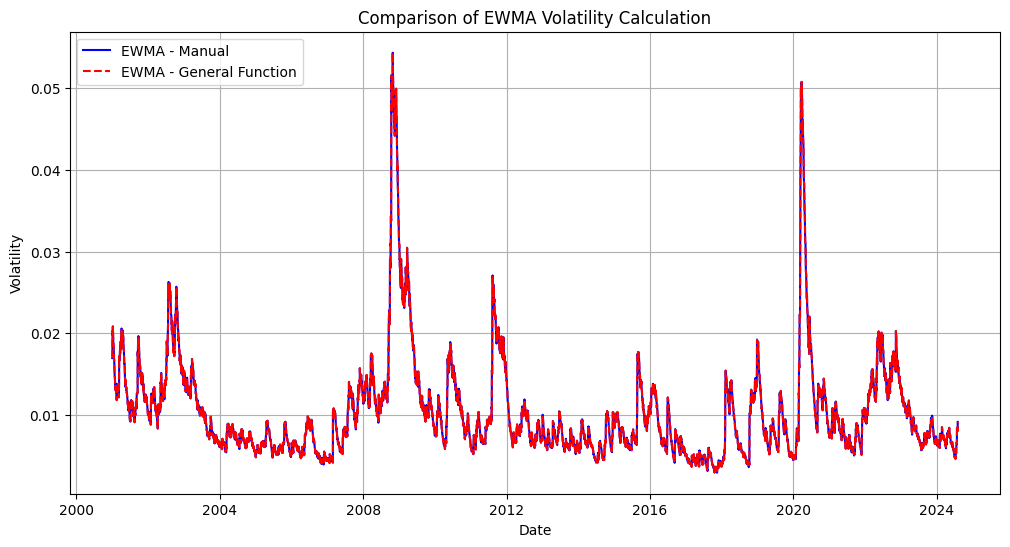

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set parameters for testing
start_date = '2001-01-02'
column_name = "Excess Market Returns"
window_size = 252
theta = 0.94
initial_vol = 0.2 / np.sqrt(252)

# Load the data (assuming 'data' DataFrame is already defined)

# Function to plot and compare manual and general results
def plot_comparison(manual_df, general_df, method_name):
    plt.figure(figsize=(12, 6))
    
    # Plot manual results
    plt.plot(manual_df.index, manual_df.values, label=f"{method_name} - Manual", linestyle='-', color='blue')
    
    # Plot general function results
    plt.plot(general_df.index, general_df.values, label=f"{method_name} - General Function", linestyle='--', color='red')
    
    plt.title(f"Comparison of {method_name} Volatility Calculation")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the `calculate_expanding_vol` function
expanding_vol_df = fa.calculate_expanding_vol(data, start_date=start_date, column_name=column_name)
print("Expanding Volatility Results:")
display(expanding_vol_df)

# Equivalent using `calculate_volatility`
expanding_vol_from_general = fa.calculate_volatility(data[column_name], method="expanding").shift(1).loc[pd.to_datetime(start_date):]
print("Expanding Volatility (General Function) Results:")
display(expanding_vol_from_general)

# Check if they are equal using `np.isclose()` and find differences
expanding_match = np.isclose(
    expanding_vol_df.values,
    expanding_vol_from_general.values,
    atol=1e-6  # Adjust tolerance if needed
)

# Identify differences
expanding_differences = expanding_vol_df[~expanding_match]
print("Differences in Expanding Volatility Calculation:")
display(expanding_differences)

# Plot comparison
plot_comparison(expanding_vol_df, expanding_vol_from_general, "Expanding")

# Test the `calculate_rolling_vol` function
rolling_vol_df = fa.calculate_rolling_vol(data, start_date=start_date, column_name=column_name, window_size=window_size)
print("Rolling Volatility Results:")
display(rolling_vol_df)

# Equivalent using `calculate_volatility`
rolling_vol_from_general = fa.calculate_volatility(data[column_name], method="rolling", window=window_size).shift(1).loc[pd.to_datetime(start_date):]
print("Rolling Volatility (General Function) Results:")
display(rolling_vol_from_general)

# Check if they are equal using `np.isclose()` and find differences
rolling_match = np.isclose(
    rolling_vol_df.values,
    rolling_vol_from_general.values,
    atol=1e-6  # Adjust tolerance if needed
)

# Identify differences
rolling_differences = rolling_vol_df[~rolling_match]
print("Differences in Rolling Volatility Calculation:")
display(rolling_differences)

# Plot comparison
plot_comparison(rolling_vol_df, rolling_vol_from_general, "Rolling")

# Test the `calculate_ewma_volatility` function
ewma_vol_df = fa.calculate_ewma_volatility(data, start_date=start_date, column_name=column_name, theta=theta, initial_sigma=initial_vol)
print("EWMA Volatility Results:")
display(ewma_vol_df)

# Equivalent using `calculate_volatility`
ewma_vol_from_general = fa.calculate_volatility(data[column_name], method="ewma", theta=theta, initial_vol=initial_vol).shift(1).loc[pd.to_datetime(start_date):]
print("EWMA Volatility (General Function) Results:")
display(ewma_vol_from_general)

# Check if they are equal using `np.isclose()` and find differences
ewma_match = np.isclose(
    ewma_vol_df.values,
    ewma_vol_from_general.values,
    atol=1e-6  # Adjust tolerance if needed
)

# Identify differences
ewma_differences = ewma_vol_df[~ewma_match]
print("Differences in EWMA Volatility Calculation:")
display(ewma_differences)

# Plot comparison
plot_comparison(ewma_vol_df, ewma_vol_from_general, "EWMA")


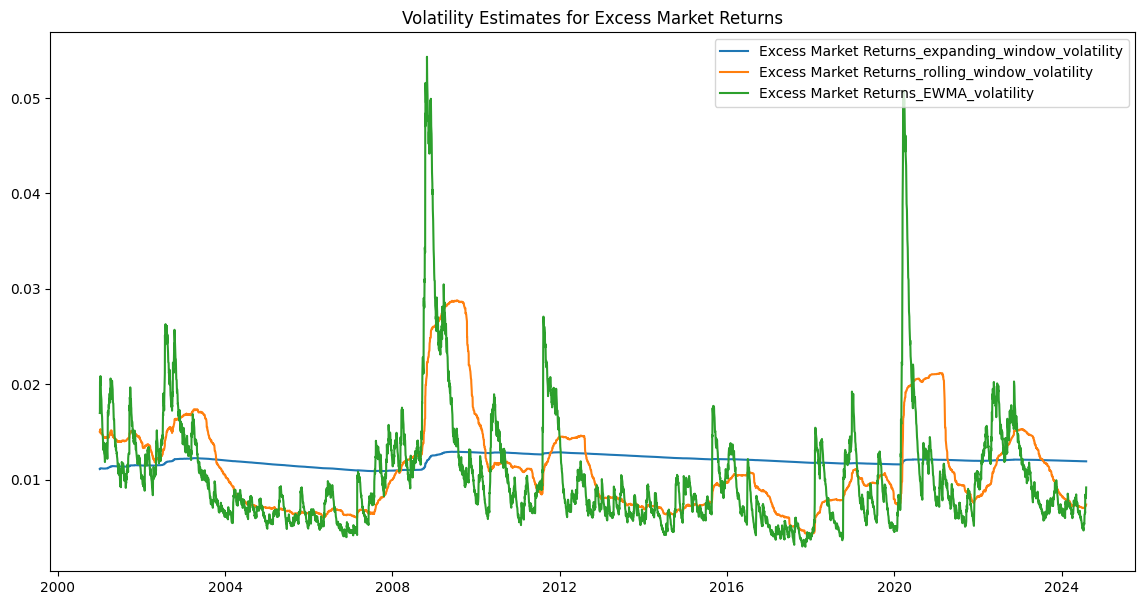

In [10]:
plot_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
plt.figure(figsize=(14, 7))
plt.plot(plot_data)
plt.title("Volatility Estimates for Excess Market Returns")
plt.legend(plot_data.columns)
plt.show()

In [19]:
# One day ahead Var

combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
one_day_ahead_data = combined_data.apply(lambda x: x *(-1.65),axis=0)
one_day_ahead_combined_data = pd.concat([data.loc[pd.to_datetime('2001-01-02'):,"Excess Market Returns"], one_day_ahead_data], axis=1)
one_day_ahead_combined_data
one_day_ahead_combined_data.eval("""
                                 VaR_Expanding = `Excess Market Returns` < `Excess Market Returns_expanding_window_volatility`
                                 VaR_Rolling = `Excess Market Returns` < `Excess Market Returns_rolling_window_volatility`
                                 VaR_EWMA = `Excess Market Returns` < `Excess Market Returns_EWMA_volatility`
                                 """, inplace=True)
one_day_ahead_combined_data.loc[:,["VaR_Expanding","VaR_Rolling","VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]

VaR_Expanding    273
VaR_Rolling      313
VaR_EWMA         355
Name: True, dtype: int64

In [21]:
from typing import Tuple, Union

def parametric_VaR_one_ahead(
    data: pd.DataFrame, 
    start_date: str, 
    column_name: str, 
    confidence_level: Union[float, None] = 0.95, 
    z_score: Union[float, None] = None, 
    window_size: int = 252, 
    theta: float = 0.94, 
    initial_vol: float = 0.2 / np.sqrt(252)
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate one-day-ahead VaR using parametric methods (expanding, rolling, EWMA) and return hit rate analysis.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The input DataFrame containing the time series of returns.
        
    start_date : str
        The start date from which to begin calculating the VaR estimates.
        
    column_name : str
        The name of the column in `data` for which VaR is to be calculated.
        
    confidence_level : float, optional (default=0.95)
        The confidence level for VaR calculation. Commonly set at 0.95 for a 5% risk threshold.
        
    z_score : float, optional (default=None)
        Directly specify a z-score for the VaR calculation instead of deriving it from the confidence level.
        
    window_size : int, optional (default=252)
        The window size for the rolling volatility calculation.
        
    theta : float, optional (default=0.94)
        The decay factor used for EWMA volatility calculation.
        
    initial_vol : float, optional (default=0.2 / sqrt(252))
        The initial volatility value used to seed the EWMA calculation.
        
    Returns:
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        - A DataFrame with the original returns, one-day-ahead VaR estimates, and indicators for VaR breaches.
        - A DataFrame summarizing hit count, hit ratio, and hit rate error for each volatility method.
        
    Usage:
    -----
    ```python
    one_day_ahead_combined_data, results = parametric_VaR_one_ahead(
        data=data, 
        start_date='2001-01-02', 
        column_name="Excess Market Returns",
        confidence_level=0.95,
        window_size=252,
        theta=0.94
    )

    print("One-Day-Ahead VaR Analysis:")
    display(one_day_ahead_combined_data.loc[:, ["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1])

    print("Hit Rate Analysis:")
    display(results)
    ```
    """
    # Determine z-score based on confidence level or use the provided z-score
    if z_score is None and confidence_level is not None:
        z_score = norm.ppf(1 - confidence_level)
    elif z_score is None:
        raise ValueError("Either `confidence_level` or `z_score` must be provided.")
    
    # Calculate the expanding, rolling, and EWMA volatilities
    expanding_vol_df = calculate_expanding_vol(data, start_date=start_date, column_name=column_name)
    rolling_vol_df = calculate_rolling_vol(data, start_date=start_date, column_name=column_name, window_size=window_size)
    ewma_vol_df = calculate_ewma_volatility(data, start_date=start_date, column_name=column_name, theta=theta, initial_sigma=initial_vol)
    
    # Combine the volatility estimates
    combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
    
    # Calculate one-day-ahead VaR by multiplying the volatilities by the negative z-score
    one_day_ahead_data = combined_data.apply(lambda x: x * z_score, axis=0)
    
    # Combine the original data with the one-day-ahead VaR estimates
    one_day_ahead_combined_data = pd.concat(
        [data.loc[pd.to_datetime(start_date):, column_name], one_day_ahead_data], 
        axis=1
    )
    
    # Evaluate whether the actual returns fall below the VaR estimates (indicating a breach)
    one_day_ahead_combined_data.eval(
        f"""
        VaR_Expanding = `{column_name}` < `{column_name}_expanding_window_volatility`
        VaR_Rolling = `{column_name}` < `{column_name}_rolling_window_volatility`
        VaR_EWMA = `{column_name}` < `{column_name}_EWMA_volatility`
        """, 
        inplace=True
    )
    
    # Calculate hit counts (the number of times actual returns are less than VaR estimates)
    hit_counts = one_day_ahead_combined_data.loc[:, ["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]
    
    # Calculate hit ratios (percentage of times actual returns are less than VaR estimates)
    total_days = len(one_day_ahead_combined_data)
    hit_ratios = hit_counts / total_days
    
    # Calculate hit rate error (difference from the expected rate, 5% or 0.05)
    expected_rate = 1 - confidence_level if confidence_level else norm.cdf(z_score)
    hit_rate_error = abs((hit_ratios / expected_rate) - 1)
    
    # Combine and return the results
    results = pd.DataFrame({
        "Hit Count": hit_counts,
        "Hit Ratio": hit_ratios,
        "Hit Rate Error": hit_rate_error
    }, index=["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"])
    
    return one_day_ahead_combined_data, results



one_day_ahead_combined_data, results, var_data = fa.parametric_VaR_one_ahead(
    data=data, 
    start_date='2001-01-02', 
    column_name="Excess Market Returns",
    z_score=-1.65)

print("One-Day-Ahead VaR Analysis:")
display(one_day_ahead_combined_data.loc[:, ["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1])

print("Hit Rate Analysis:")
display(results)

display(var_data)

pmh.calc_var_cvar_summary(data["Excess Market Returns"],
                          window=252,
                          z_score=-1.65,
                          drop_columns=["GARCH"]
                          ).tail()

One-Day-Ahead VaR Analysis:


VaR_Expanding    273
VaR_Rolling      313
VaR_EWMA         355
Name: True, dtype: int64

Hit Rate Analysis:


,Hit Count,Hit Ratio,Hit Rate Error
VaR_Expanding,273,0.0461,0.0788
VaR_Rolling,313,0.0528,0.0562
VaR_EWMA,355,0.0599,0.1979


,Expanding_window_VaR,Rolling_window_VaR,EWMA_VaR
date,,,
2001-01-02,-0.0183,-0.0248,-0.0280
2001-01-03,-0.0183,-0.0249,-0.0282
2001-01-04,-0.0184,-0.0250,-0.0334
2001-01-05,-0.0184,-0.0250,-0.0327
2001-01-08,-0.0185,-0.0252,-0.0344
...,...,...,...
2024-07-29,-0.0197,-0.0120,-0.0140
2024-07-30,-0.0197,-0.0120,-0.0135
2024-07-31,-0.0197,-0.0120,-0.0133


VaR and CVaR are given shifted by 1.000000 period(s).


,Returns,Expanding 252 Historical VaR (5.00%),Rolling 252 Historical VaR (5.00%),Expanding 252 Volatility,Rolling 252 Volatility,EWMA 0.94 Volatility,Expanding 252 Parametric VaR (5.00%),Rolling 252 Parametric VaR (5.00%),EWMA 0.94 Parametric VaR (5.00%),Expanding 252 Historical CVaR (5.00%),Rolling 252 Historical CVaR (5.00%),Expanding 252 Parametrical CVaR (5.00%),Rolling 252 Parametrical CVaR (5.00%),EWMA 0.94 Parametrical CVaR (5.00%)
date,,,,,,,,,,,,,,
2024-07-29,0.0110,-0.0185,-0.0136,0.0119,0.0073,0.0085,-0.0197,-0.0120,-0.0140,-0.0284,-0.0154,-0.0244,-0.0149,-0.0173
2024-07-30,0.0004,-0.0185,-0.0136,0.0119,0.0073,0.0082,-0.0197,-0.0120,-0.0135,-0.0284,-0.0154,-0.0244,-0.0149,-0.0168
2024-07-31,-0.0053,-0.0185,-0.0136,0.0119,0.0073,0.0081,-0.0197,-0.0120,-0.0133,-0.0284,-0.0154,-0.0244,-0.0149,-0.0165
2024-08-01,0.0161,-0.0185,-0.0136,0.0119,0.0073,0.0087,-0.0197,-0.0121,-0.0144,-0.0284,-0.0154,-0.0244,-0.0150,-0.0179
2024-08-02,-0.0144,-0.0185,-0.0138,0.0119,0.0074,0.0092,-0.0197,-0.0122,-0.0151,-0.0284,-0.0154,-0.0244,-0.0151,-0.0188


In [22]:
def parametric_CVaR_one_ahead(
    data: pd.DataFrame, 
    start_date: str, 
    column_name: str, 
    confidence_level: Union[float, None] = 0.95, 
    z_score: Union[float, None] = None, 
    window_size: int = 252, 
    theta: float = 0.94, 
    initial_vol: float = 0.2 / np.sqrt(252)
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculate one-day-ahead Conditional Value at Risk (CVaR) using parametric methods (expanding, rolling, EWMA) 
    and return hit rate analysis along with CVaR estimates.
    
    Parameters:
    ----------
    data : pd.DataFrame
        The input DataFrame containing the time series of returns.
        
    start_date : str
        The start date from which to begin calculating the CVaR estimates.
        
    column_name : str
        The name of the column in `data` for which CVaR is to be calculated.
        
    confidence_level : float, optional (default=0.95)
        The confidence level for CVaR calculation. Commonly set at 0.95, which corresponds to a 5% risk threshold.
        
    z_score : float, optional (default=None)
        Directly specify a z-score for the CVaR calculation instead of deriving it from the confidence level. 
        If provided, this value will override the calculation from `confidence_level`.
        
    window_size : int, optional (default=252)
        The window size for the rolling volatility calculation.
        
    theta : float, optional (default=0.94)
        The decay factor used for EWMA (Exponentially Weighted Moving Average) volatility calculation.
        
    initial_vol : float, optional (default=0.2 / sqrt(252))
        The initial volatility value used to seed the EWMA calculation.
        
    Returns:
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        - A DataFrame with the original returns, one-day-ahead CVaR estimates, and indicators for CVaR breaches.
        - A DataFrame summarizing hit count, hit ratio, and hit rate error for each volatility method.
        - A DataFrame showing the one-day-ahead CVaR estimates calculated using each method.
        
    Explanation:
    ------------
    This function calculates one-day-ahead CVaR estimates for a given financial time series using three volatility estimation methods:
    
    1. **Expanding Volatility**: Measures volatility over an expanding window, updating as more data points are included.
    2. **Rolling Volatility**: Measures volatility over a fixed-size rolling window, providing a moving measure that adjusts as the window slides over time.
    3. **EWMA (Exponentially Weighted Moving Average) Volatility**: Uses a decay factor to give more weight to recent data, capturing recent volatility patterns.

    The function converts the confidence level into a z-score, which is used to scale the volatility estimates into CVaR estimates. 
    It also checks whether the actual returns fall below the CVaR estimates, indicating breaches, and calculates hit rates for each method. 
    Finally, it provides a summary of the hit counts, hit ratios, and hit rate errors for each method.

    Usage:
    -----
    ```python
one_day_ahead_combined_data, hit_rate_results, cvar_historical = parametric_CVaR_one_ahead(data,start_date='2001-01-02',column_name="Excess Market Returns",z_score=-1.65,window_size=252,theta=0.94,initial_vol=0.2 / np.sqrt(252))
print("One-Day-Ahead CVaR Analysis:")
display(one_day_ahead_combined_data.loc[:, ["CVaR_Expanding", "CVaR_Rolling", "CVaR_EWMA"]].apply(pd.Series.value_counts).iloc[1])

print("Hit Rate Analysis:")
display(hit_rate_results)

print("Historical CVaR Estimates:")
display(cvar_historical)
    ```
    """
    # Determine z-score based on confidence level or use the provided z-score
    if z_score is None and confidence_level is not None:
        z_score = norm.ppf(1 - confidence_level)
    elif z_score is None:
        raise ValueError("Either `confidence_level` or `z_score` must be provided.")
    
    # Convert z-score for CVaR (using -norm.pdf(z_score) / quantile_level)
    quantile_level = 1 - confidence_level
    cvar_factor = -norm.pdf(z_score) / quantile_level
    
    # Calculate the expanding, rolling, and EWMA volatilities
    expanding_vol_df = calculate_expanding_vol(data, start_date=start_date, column_name=column_name)
    rolling_vol_df = calculate_rolling_vol(data, start_date=start_date, column_name=column_name, window_size=window_size)
    ewma_vol_df = calculate_ewma_volatility(data, start_date=start_date, column_name=column_name, theta=theta, initial_sigma=initial_vol)
    
    # Combine the volatility estimates
    combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
    
    # Calculate one-day-ahead CVaR by multiplying the volatilities by the CVaR factor
    one_day_ahead_data = combined_data.apply(lambda x: x * cvar_factor, axis=0)
    
    # Combine the original data with the one-day-ahead CVaR estimates
    one_day_ahead_combined_data = pd.concat(
        [data.loc[pd.to_datetime(start_date):, column_name], one_day_ahead_data], 
        axis=1
    )
    
    # Evaluate whether the actual returns fall below the CVaR estimates (indicating a breach)
    one_day_ahead_combined_data.eval(
        f"""
        CVaR_Expanding = `{column_name}` < `{column_name}_expanding_window_volatility`
        CVaR_Rolling = `{column_name}` < `{column_name}_rolling_window_volatility`
        CVaR_EWMA = `{column_name}` < `{column_name}_EWMA_volatility`
        """, 
        inplace=True
    )
    
    # Calculate hit counts (the number of times actual returns are less than CVaR estimates)
    hit_counts = one_day_ahead_combined_data.loc[:, ["CVaR_Expanding", "CVaR_Rolling", "CVaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]
    
    # Calculate hit ratios (percentage of times actual returns are less than CVaR estimates)
    total_days = len(one_day_ahead_combined_data)
    hit_ratios = hit_counts / total_days
    
    # Calculate hit rate error (difference from the expected rate, 5% or 0.05)
    expected_rate = quantile_level
    hit_rate_error = abs((hit_ratios / expected_rate) - 1)
    
    # Combine the hit rate results
    hit_rate_results = pd.DataFrame({
        "Hit Count": hit_counts,
        "Hit Ratio": hit_ratios,
        "Hit Rate Error": hit_rate_error
    }, index=["CVaR_Expanding", "CVaR_Rolling", "CVaR_EWMA"])
    one_day_ahead_data.columns = ["Expanding_window_CVaR", "Rolling_window_CVaR", "EWMA_CVaR"]
    return one_day_ahead_combined_data, hit_rate_results, one_day_ahead_data

one_day_ahead_combined_data, hit_rate_results, cvar_historical = fa.parametric_CVaR_one_ahead(data,start_date='2001-01-02',column_name="Excess Market Returns",z_score=-1.65,window_size=252,theta=0.94,initial_vol=0.2 / np.sqrt(252))
print("One-Day-Ahead CVaR Analysis:")
display(one_day_ahead_combined_data.loc[:, ["CVaR_Expanding", "CVaR_Rolling", "CVaR_EWMA"]].apply(pd.Series.value_counts).iloc[1])

print("Hit Rate Analysis:")
display(hit_rate_results)

print("Historical CVaR Estimates:")
display(cvar_historical)

One-Day-Ahead CVaR Analysis:


CVaR_Expanding    153
CVaR_Rolling      197
CVaR_EWMA         196
Name: True, dtype: int64

Hit Rate Analysis:


,Hit Count,Hit Ratio,Hit Rate Error
CVaR_Expanding,153,0.0258,0.4837
CVaR_Rolling,197,0.0332,0.3352
CVaR_EWMA,196,0.0331,0.3386


Historical CVaR Estimates:


,Expanding_window_CVaR,Rolling_window_CVaR,EWMA_CVaR
date,,,
2001-01-02,-0.0227,-0.0308,-0.0347
2001-01-03,-0.0227,-0.0308,-0.0349
2001-01-04,-0.0228,-0.0310,-0.0415
2001-01-05,-0.0228,-0.0310,-0.0406
2001-01-08,-0.0229,-0.0313,-0.0426
...,...,...,...
2024-07-29,-0.0244,-0.0149,-0.0173
2024-07-30,-0.0244,-0.0149,-0.0168
2024-07-31,-0.0244,-0.0149,-0.0165


In [33]:
# Combine the volatility estimates
combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)

# Calculate one-day-ahead VaR by multiplying the volatilities by -1.65 (assuming a 95% confidence level)
one_day_ahead_data = combined_data.apply(lambda x: x * (-1.65), axis=0)

# Combine the original data with the one-day-ahead VaR estimates
one_day_ahead_combined_data = pd.concat(
    [data.loc[pd.to_datetime('2001-01-02'):, "Excess Market Returns"], one_day_ahead_data], 
    axis=1
)

# Evaluate whether the actual returns fall below the VaR estimates (indicating a breach)
one_day_ahead_combined_data.eval(
    """
    VaR_Expanding = `Excess Market Returns` < `Excess Market Returns_expanding_window_volatility`
    VaR_Rolling = `Excess Market Returns` < `Excess Market Returns_rolling_window_volatility`
    VaR_EWMA = `Excess Market Returns` < `Excess Market Returns_EWMA_volatility`
    """, 
    inplace=True
)

# Calculate hit counts (the number of times actual returns are less than VaR estimates)
hit_counts = one_day_ahead_combined_data.loc[:, ["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]

# Calculate hit ratios (percentage of times actual returns are less than VaR estimates)
total_days = len(one_day_ahead_combined_data)
hit_ratios = hit_counts / total_days

# Calculate hit rate error (difference from the expected rate, 5% or 0.05)
expected_rate = 0.05
hit_rate_error = abs((hit_ratios / expected_rate) - 1)

# Combine and display the results
results = pd.DataFrame({
    "Hit Count": hit_counts,
    "Hit Ratio": hit_ratios,
    "Hit Rate Error": hit_rate_error
}, index=["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"])

print("One-Day-Ahead VaR Analysis:")
display(one_day_ahead_combined_data.loc[:, ["VaR_Expanding", "VaR_Rolling", "VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1])

print("Hit Rate Analysis:")
display(results)


One-Day-Ahead VaR Analysis:


VaR_Expanding    273
VaR_Rolling      313
VaR_EWMA         355
Name: True, dtype: int64

Hit Rate Analysis:


,Hit Count,Hit Ratio,Hit Rate Error
VaR_Expanding,273,0.0461,0.0788
VaR_Rolling,313,0.0528,0.0562
VaR_EWMA,355,0.0599,0.1979


***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

In [12]:
from scipy.stats import norm
z_score= 0.05
quantile_level = 0.05
combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
one_day_ahead_data = combined_data.apply(lambda x: x *(-norm.pdf(z_score)/quantile_level),axis=0)
one_day_ahead_combined_data = pd.concat([data.loc[pd.to_datetime('2001-01-02'):,"Excess Market Returns"], one_day_ahead_data], axis=1)
one_day_ahead_combined_data
one_day_ahead_combined_data.eval("""
                                 CVaR_Expanding = `Excess Market Returns` < `Excess Market Returns_expanding_window_volatility`
                                 CVaR_Rolling = `Excess Market Returns` < `Excess Market Returns_rolling_window_volatility`
                                 CVaR_EWMA = `Excess Market Returns` < `Excess Market Returns_EWMA_volatility`
                                 """, inplace=True)
one_day_ahead_combined_data.loc[:,["CVaR_Expanding","CVaR_Rolling","CVaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]

CVaR_Expanding    3
CVaR_Rolling      3
CVaR_EWMA         2
Name: True, dtype: int64

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [13]:
# from arch import arch_model
# from dask.distributed import Client

# results = {}

# # Set end location for rolling window
# end_loc = np.where(data.index >= pd.to_datetime('2000-12-29'))[0].min()

# # Define GARCH model
# am = arch_model(data["Excess Market Returns"], vol='Garch', p=1, q=1, dist='Normal')

# # Function to fit GARCH model and forecast variance
# def fit_garch(first_obs, last_obs):
#     res = am.fit(first_obs=first_obs, last_obs=last_obs, disp='off')
#     temp = res.forecast(horizon=1).variance
#     return temp.iloc[0]

# # Use a with-statement to automatically manage the Dask client
# with Client() as client:
#     print(client.ncores())
#     print(client.nthreads)

#     # Submit GARCH fitting tasks to Dask
#     futures = []
#     for i in range(len(data["Excess Market Returns"]) - end_loc):
#         future = client.submit(fit_garch, i, i + end_loc)
#         futures.append(future)

#     # Collect results as they complete
#     results = [future.result() for future in futures]

# # Convert results into a DataFrame
# forecast_df = pd.concat(results, axis=0).reset_index(drop=True)
# forecast_df.columns = ["Forecast Variance"]

# # Display the cleaned-up DataFrame
# print(forecast_df.head())
    

In [14]:
len(forecast_df)

NameError: name 'forecast_df' is not defined

In [29]:
len(data.loc[:'2001-01-02', "Excess Market Returns"])

1754